In [1]:
import os
import re
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# Load class name mapping
mapping_file = "imagenet_class_name_mapping.txt"
synset_to_name = {}
with open(mapping_file, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) >= 3:
            synset_id = parts[0]
            class_name = parts[2].replace('_', ' ')
            synset_to_name[synset_id] = class_name

# Read CSV and extract data
csv_path = "imagenet_examples.csv"
with open(csv_path, "r") as f:
    content = f.read().strip()
    if content.startswith('"') and content.endswith('"'):
        content = content[1:-1]
    paths = [p.strip() for p in content.split(",") if p.strip()]

# Extract class info and assign bins
data = []
for idx, path in enumerate(paths):
    match = re.search(r'/([n]\d{8})/', path)
    class_id = match.group(1) if match else "unknown"
    class_name = synset_to_name.get(class_id, class_id)
    difficulty_bin = min(idx // 10000, 4)
    data.append({'class_name': class_name, 'difficulty_bin': difficulty_bin})

df = pd.DataFrame(data)
print(f"Loaded {len(df)} samples with {len(synset_to_name)} class mappings")


Loaded 50000 samples with 1000 class mappings


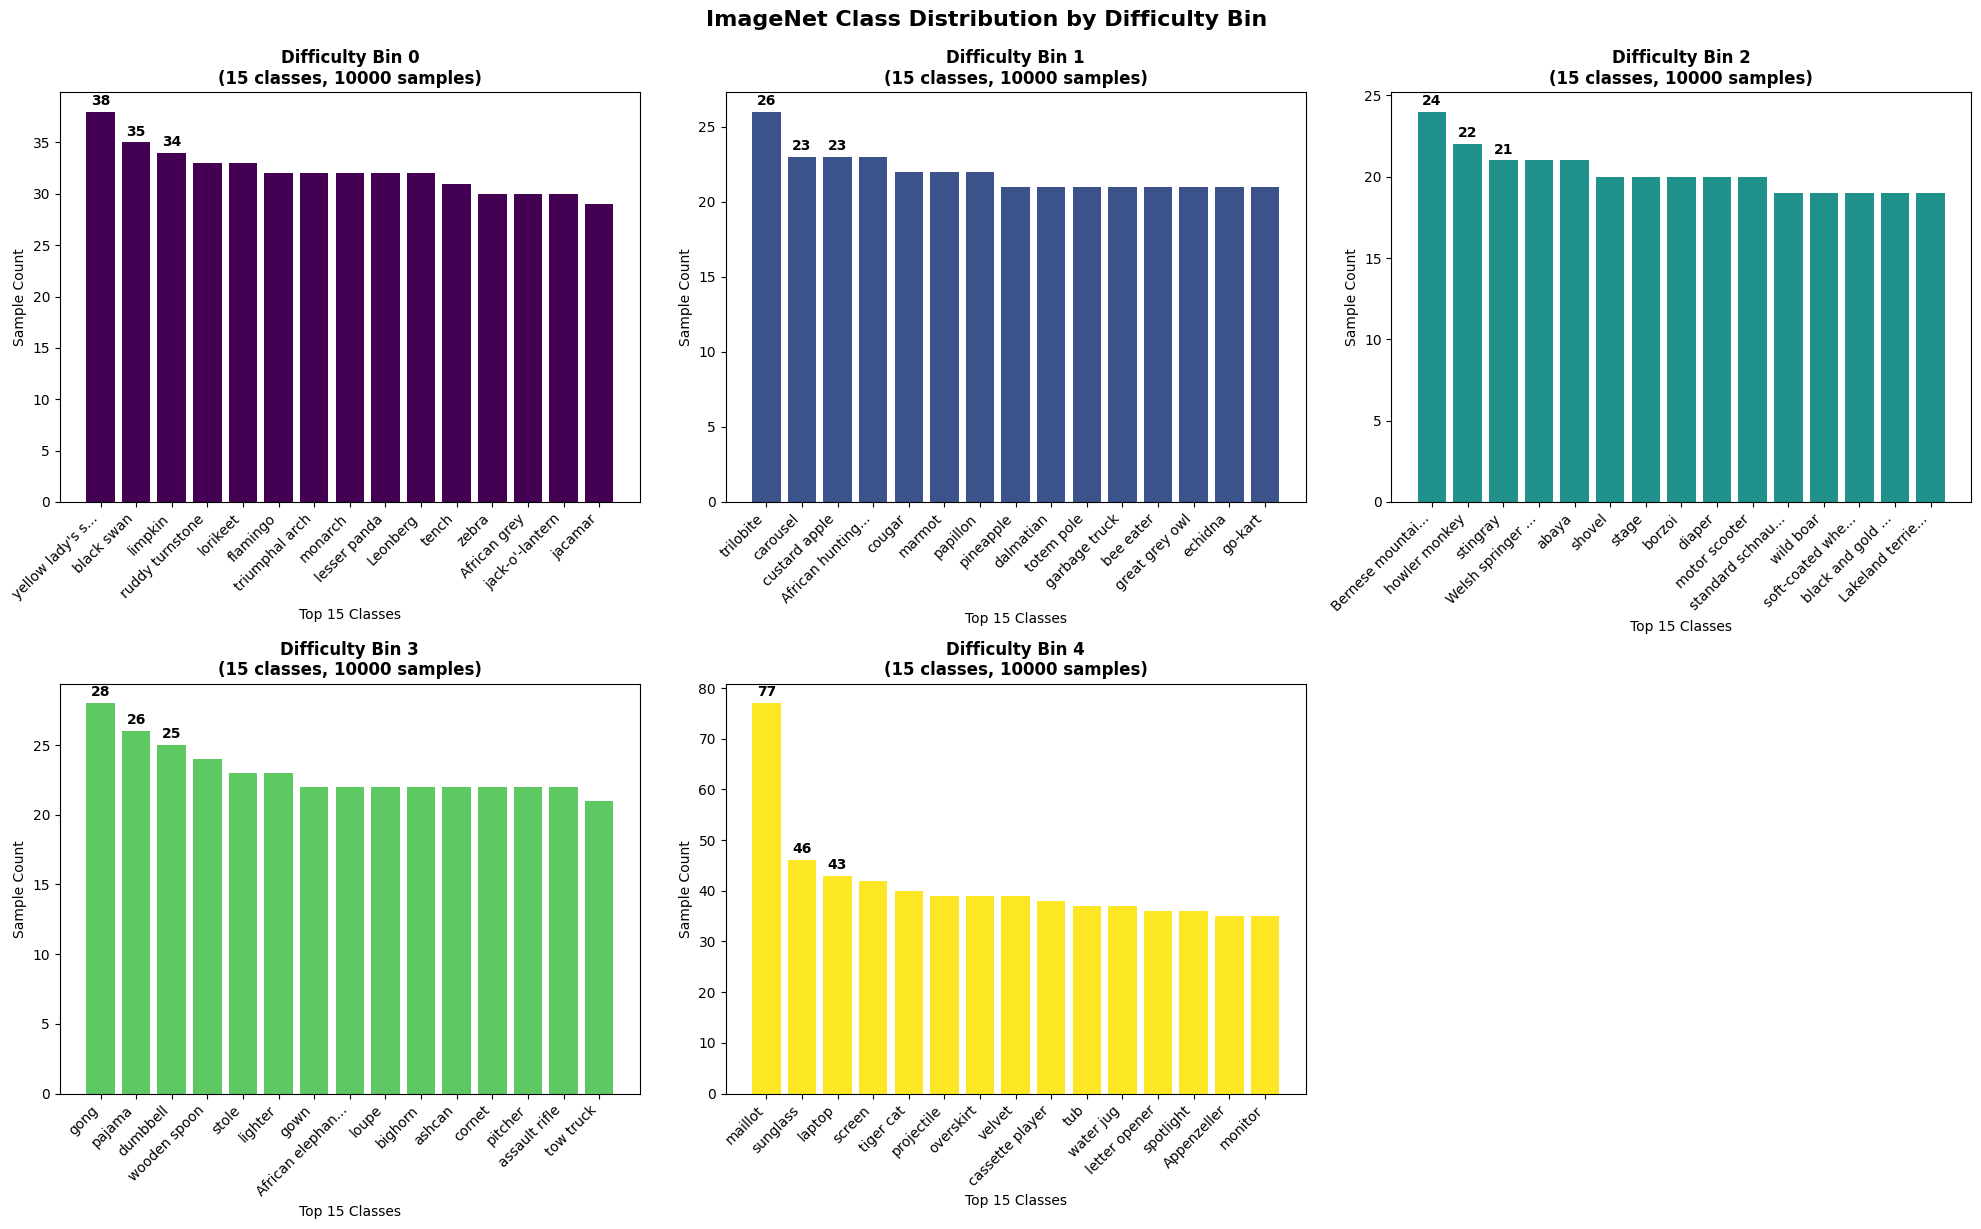

In [2]:
# Create 5 histograms
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for bin_idx in range(5):
    ax = axes[bin_idx]
    bin_data = df[df['difficulty_bin'] == bin_idx]
    
    if len(bin_data) > 0:
        class_counts = bin_data['class_name'].value_counts().head(15)
        
        ax.bar(range(len(class_counts)), class_counts.values, color=plt.cm.viridis(bin_idx / 4))
        ax.set_title(f'Difficulty Bin {bin_idx}\n({len(class_counts)} classes, {len(bin_data)} samples)', fontweight='bold')
        ax.set_xlabel('Top 15 Classes')
        ax.set_ylabel('Sample Count')
        
        # Truncate long names for display
        labels = [name[:15] + "..." if len(name) > 15 else name for name in class_counts.index]
        ax.set_xticks(range(len(class_counts)))
        ax.set_xticklabels(labels, rotation=45, ha='right')
        
        # Add count labels on top 3 bars
        for i in range(min(3, len(class_counts))):
            ax.text(i, class_counts.iloc[i] + max(class_counts.values) * 0.01, 
                   str(class_counts.iloc[i]), ha='center', va='bottom', fontweight='bold')

# Remove empty subplot
axes[5].remove()
plt.tight_layout()
plt.suptitle('ImageNet Class Distribution by Difficulty Bin', fontsize=16, fontweight='bold', y=1.02)
plt.show()


In [ ]:
# Create 5 histograms with FIXED x-axis (all classes present)
# Get all unique classes across all bins
all_classes = df['class_name'].value_counts().head(20).index.tolist()  # Top 20 most common overall

fig, axes = plt.subplots(2, 3, figsize=(24, 12))
axes = axes.flatten()

for bin_idx in range(5):
    ax = axes[bin_idx]
    bin_data = df[df['difficulty_bin'] == bin_idx]
    
    if len(bin_data) > 0:
        # Get counts for ALL classes (including zeros)
        class_counts = bin_data['class_name'].value_counts()
        counts_for_all_classes = [class_counts.get(cls, 0) for cls in all_classes]
        
        ax.bar(range(len(all_classes)), counts_for_all_classes, color=plt.cm.viridis(bin_idx / 4))
        ax.set_title(f'Difficulty Bin {bin_idx} - Fixed Axis\n({len(class_counts)} unique classes, {len(bin_data)} samples)', fontweight='bold')
        ax.set_xlabel('All Top Classes (Fixed Order)')
        ax.set_ylabel('Sample Count')
        
        # Truncate long names for display
        labels = [name[:12] + "..." if len(name) > 12 else name for name in all_classes]
        ax.set_xticks(range(len(all_classes)))
        ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
        
        # Add count labels on bars with counts > 0
        for i, count in enumerate(counts_for_all_classes):
            if count > 0:
                ax.text(i, count + max(counts_for_all_classes) * 0.01, 
                       str(count), ha='center', va='bottom', fontweight='bold', fontsize=8)

# Remove empty subplot
axes[5].remove()
plt.tight_layout()
plt.suptitle('ImageNet Class Distribution by Difficulty Bin (Fixed X-Axis)', fontsize=16, fontweight='bold', y=1.02)
plt.show()
